## Mantenimiento Predictivo de Máquinas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

## 1.- Carga del dataset y análisis exploratorio inicial

In [3]:
datos = pd.read_csv("predictive_maintenance.csv")

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


Por lo tanto, no hay datos nulos, ya que de 10000 entradas, 10000 son datos no nulos. Además identificamos 3 features de tipo categórico, siendo `Product ID`, `Type` y `Failure Type`. Donde la única feature categórica útil que mantendremos será `Type`. `Product ID` y `Failure Type` se eliminarán más adelante, en el paso de preprocesamiento.

In [4]:
datos

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


## 2.- EDA

In [5]:
datos.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


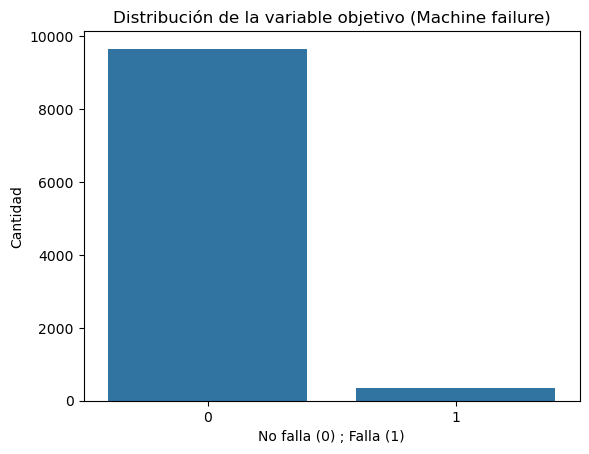

Target
0    9661
1     339
Name: count, dtype: int64


In [6]:
sns.countplot(x='Target', data=datos)
plt.title("Distribución de la variable objetivo (Machine failure)")
plt.xlabel("No falla (0) ; Falla (1)")
plt.ylabel("Cantidad")
plt.show()

print(datos["Target"].value_counts())

Como podemos observar, de 10000 máquinas, solo 339 fallan.

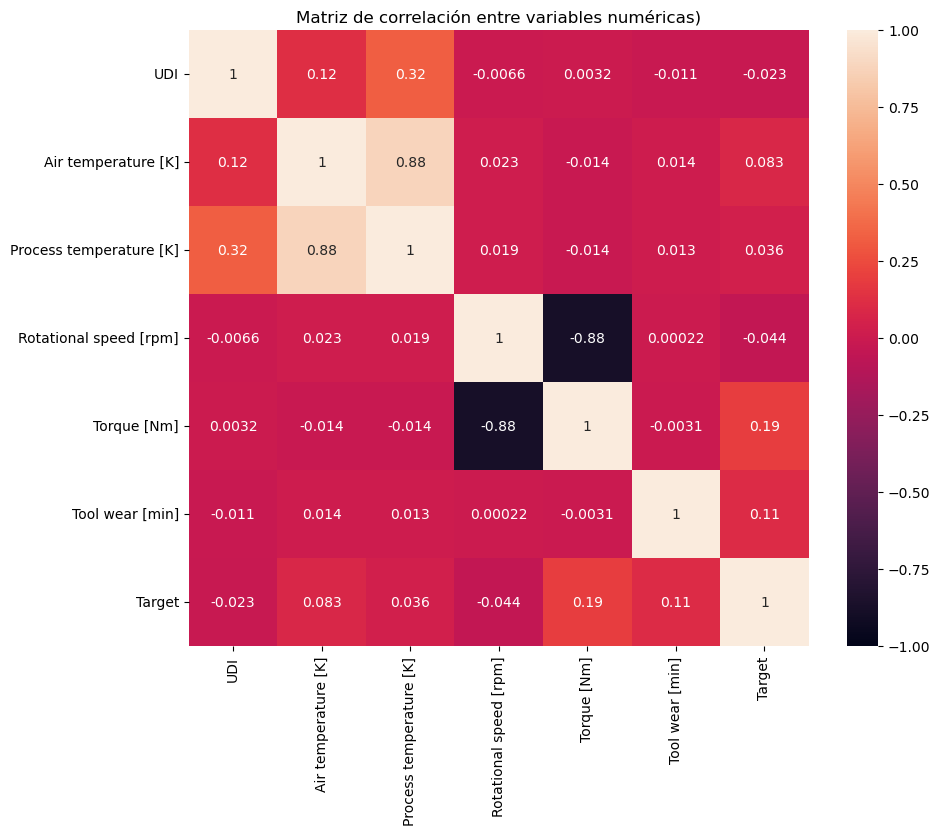

In [7]:
datos_numericos = datos.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(10,8))
sns.heatmap(datos_numericos.corr(), vmin=-1, vmax=1, annot=True)
plt.title("Matriz de correlación entre variables numéricas)")
plt.show()

Nos interesa saber que variables guardan mayor correlación con la variable objetivo `Target`. Observando el mapa de calor podemos apreciar que la feature que guarda mayor correlación con `Target`es `Torque [Nm]`, siendo de 0.19, la cual es una correlación débil. Mientras que se puede observar como existe una alta correlación positiva entre `Air temperature [K]` y `Process temperature [K]`. Por otro lado, `Rotational speed [rpm]` tiene una alta correlación negativa con `Torque [Nm]`. Probablemente esto puede estar indicando que existe una relación no lineal entre las features y la variable objetivo, por lo que el modelo de Random Forest podría ser de utilidad.

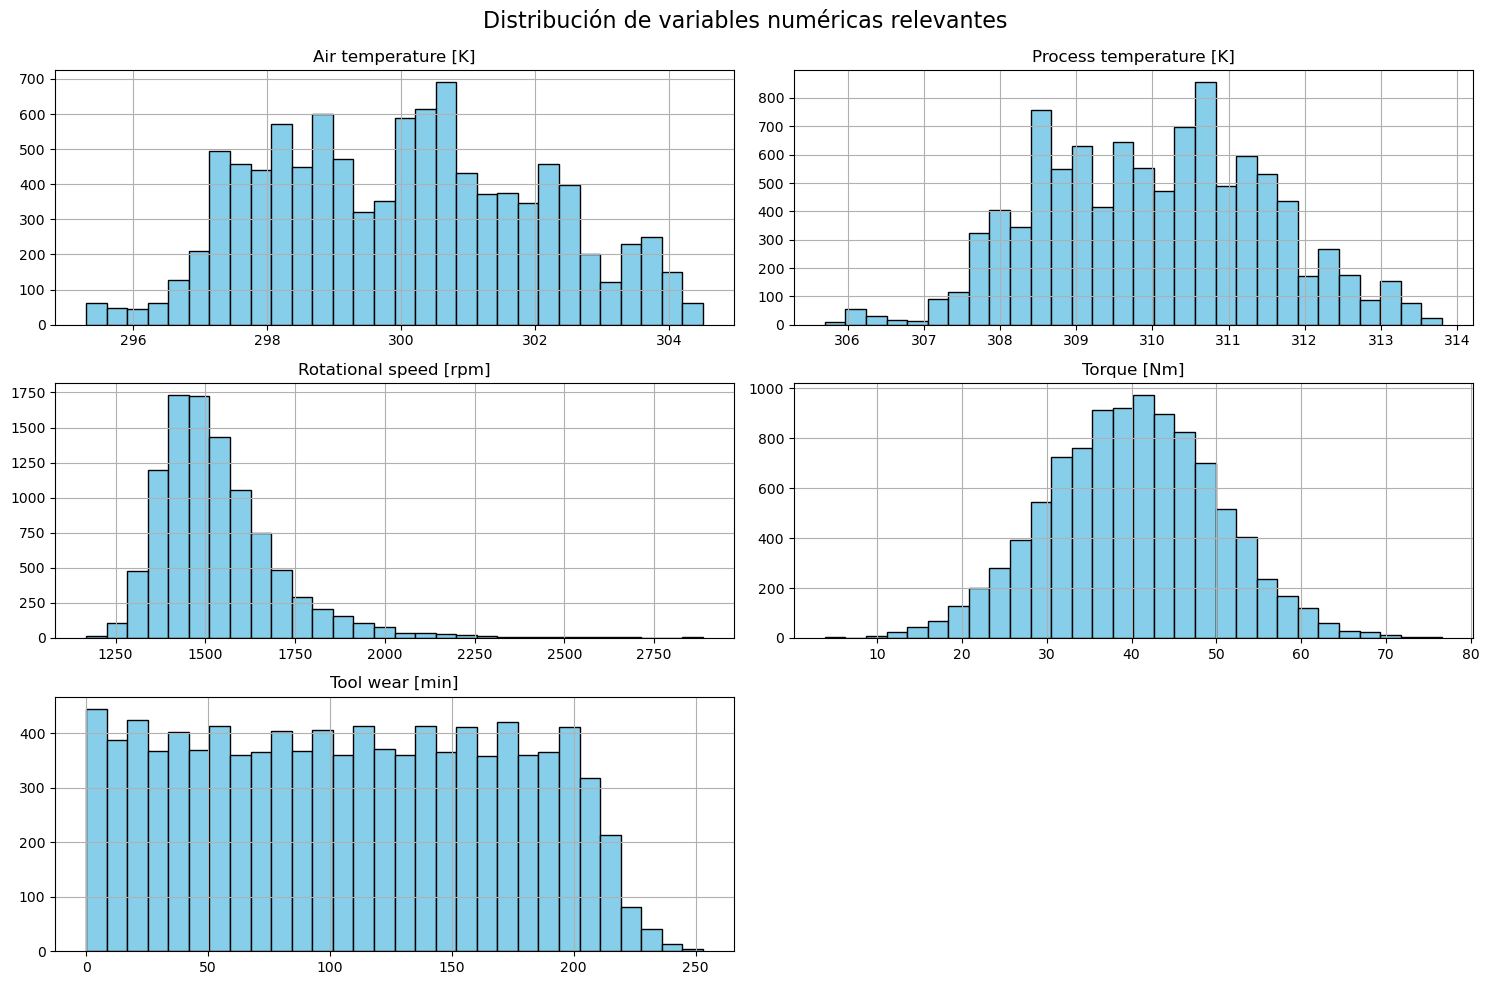

In [8]:
columnas_relevantes = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]

datos[columnas_relevantes].hist(bins=30, figsize=(15,10), color="skyblue", edgecolor="black")
plt.suptitle("Distribución de variables numéricas relevantes", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


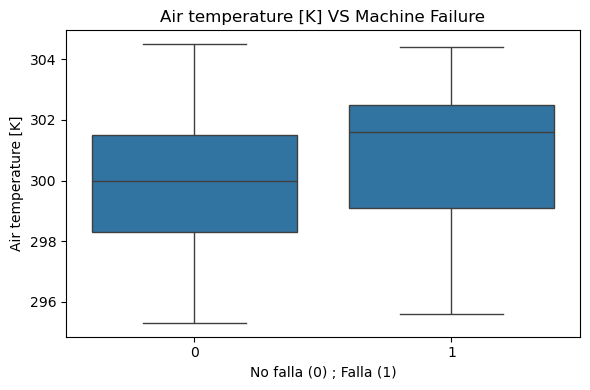

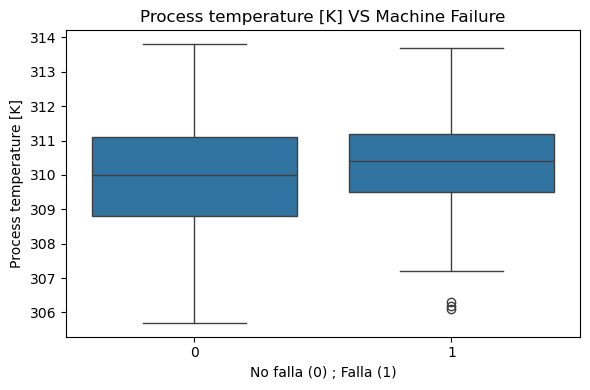

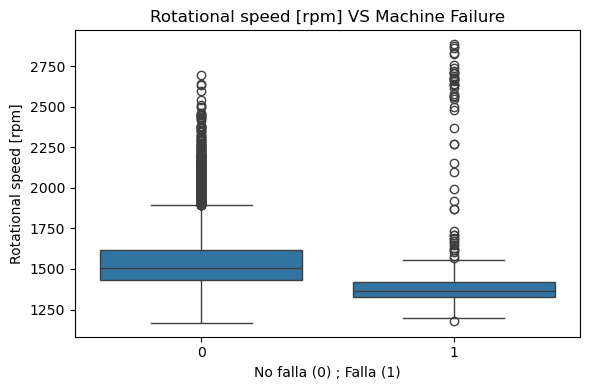

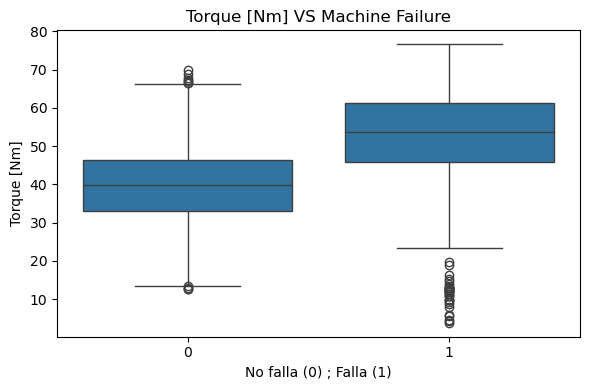

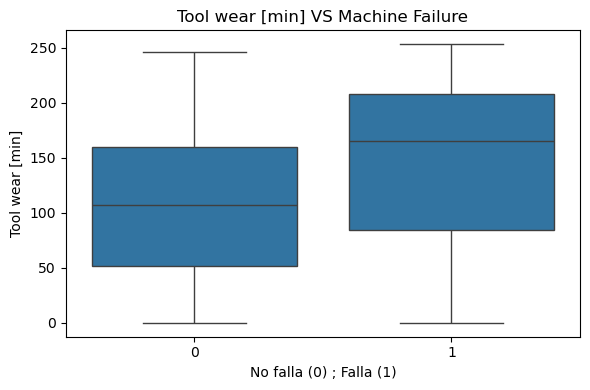

In [9]:
columnas_numericas = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]

for col in columnas_numericas:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Target", y=col, data=datos)
    plt.title(f"{col} VS Machine Failure")
    plt.xlabel("No falla (0) ; Falla (1)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [10]:
print(datos["Type"].value_counts())

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64


## 3.- Preprocessing y Feature Engineering

In [11]:
df = datos.copy()
df = df.drop(columns=["UDI", "Product ID", "Failure Type"])


In [12]:
df = pd.get_dummies(df, columns=["Type"], drop_first=True)

La feature `Type` se convierte a booleano. Donde H aparece cuando L y M son falsas a la vez.

In [13]:
df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,False,True
1,298.2,308.7,1408,46.3,3,0,True,False
2,298.1,308.5,1498,49.4,5,0,True,False
3,298.2,308.6,1433,39.5,7,0,True,False
4,298.2,308.7,1408,40.0,9,0,True,False


## 4.- Selección del modelo y entrenamiento

## Decision Tree

Este primer bloque dedicado a Decision Tree tiene la intención de servir como una base con la cual poder comparar el Random Forest a posterior. Por ende, en el bloque de Decision Tree aplicaremos sus métricas de desempeño, con el fin de observar su rendimiento. Mas no se le aplicará control de overfitting ni se buscará ajustar sus parámetros, ya que nuestro enfoque es el Random Forest.

In [14]:
X = df.drop(columns=["Target"])
y = df["Target"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Stratify ayuda a que haya balance de clases :)

In [16]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

y_pred_dt = model_dt.predict(X_test)

print("Classification Report - Decision Tree")
print(classification_report(y_test, y_pred_dt))

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.68      0.66      0.67        68

    accuracy                           0.98      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.98      0.98      0.98      2000



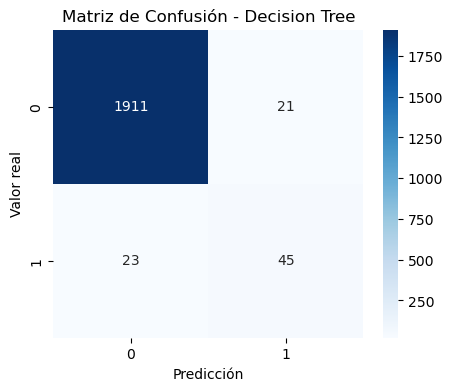

In [17]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(5,4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Decision Tree")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

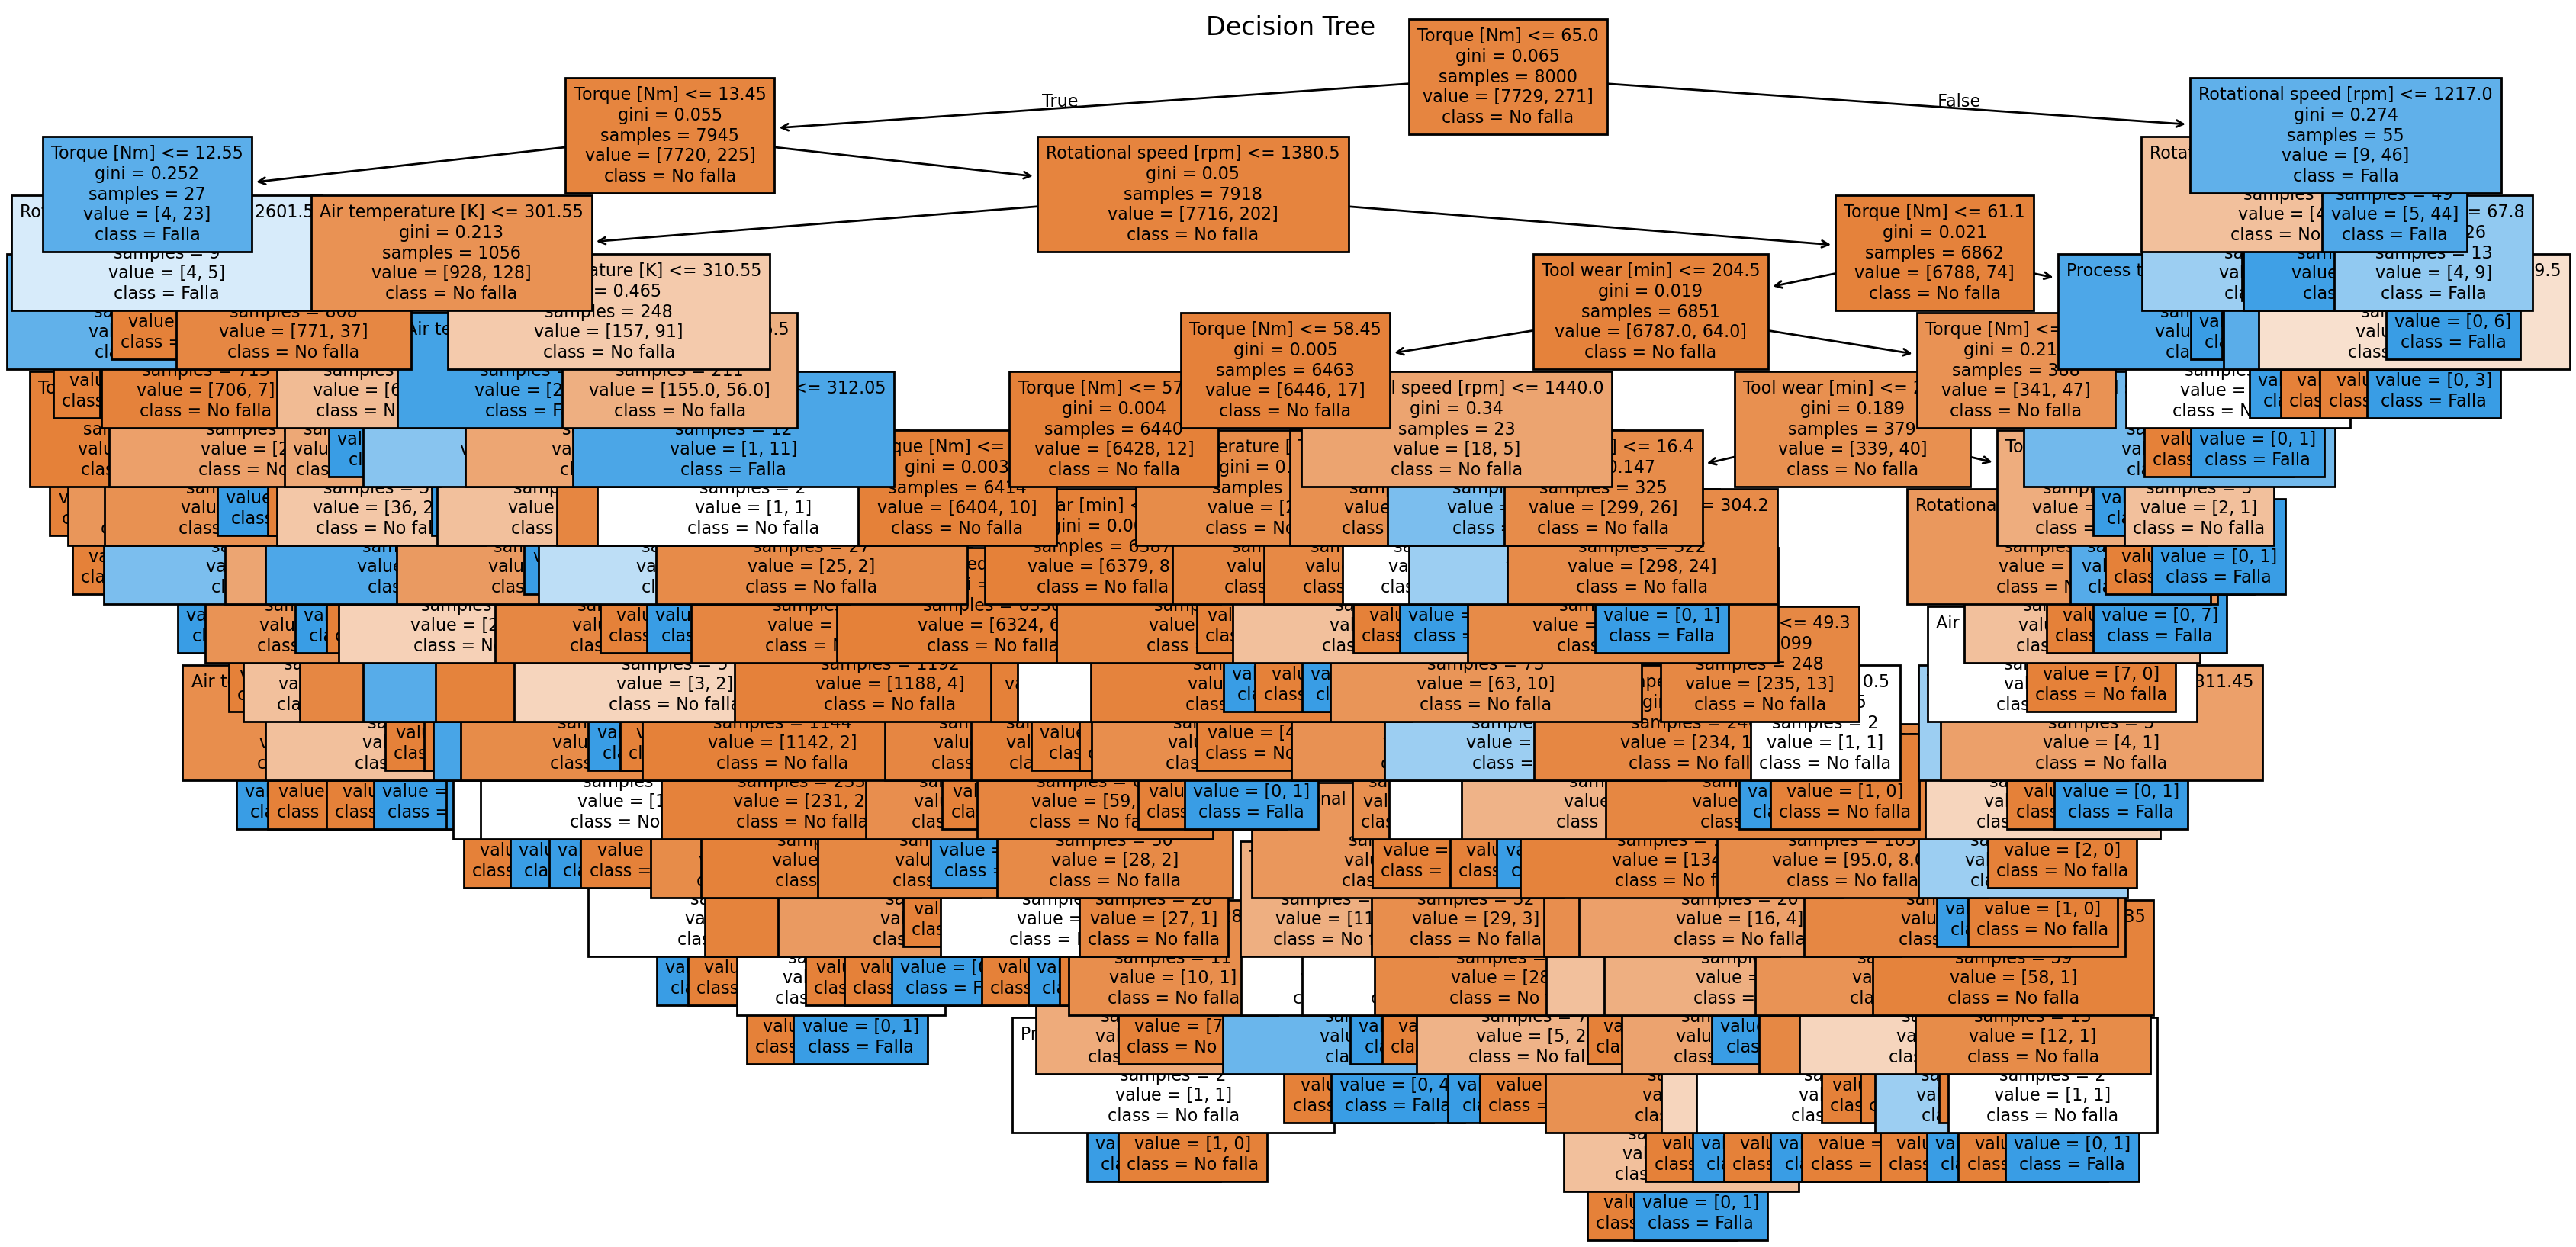

In [18]:
plt.figure(figsize=(20, 10), dpi=200)

plot_tree(
    model_dt,  
    filled=True,
    feature_names=X.columns,  
    class_names=["No falla", "Falla"], 
    fontsize=8
)

plt.title("Decision Tree")
plt.show()

## Random Forest

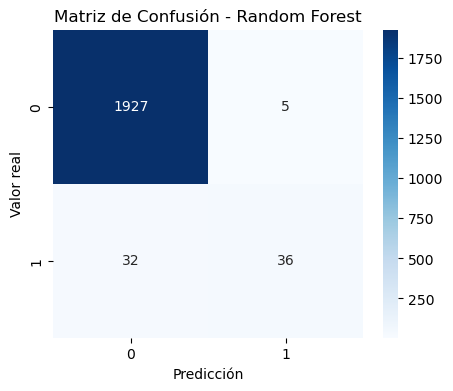

Classification Report - Random Forest con n_estimators = 100
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.88      0.53      0.66        68

    accuracy                           0.98      2000
   macro avg       0.93      0.76      0.83      2000
weighted avg       0.98      0.98      0.98      2000



In [19]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

#Evaluaremos métricas aquí brevemente para tener una base comparativa del random forest sin ajustes
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

print("Classification Report - Random Forest con n_estimators = 100")
print(classification_report(y_test, y_pred_rf))

## 5.- Control de Overfitting

In [20]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Modelo base de Random Forest con pesos balanceados
rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)

# GridSearchCV con cross-validation de 5 folds
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # F1 da más peso a la clase minoritaria
    n_jobs=-1, # Se usan todos los procesadores (CPU)
    verbose=1 # Se muestran mensajes simples acerca del progreso
)

# Se entrena sobre el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Se obtiene el mejor modelo y sus parámetros
mejor_rf = grid_search.best_estimator_
print("La mejor combinación de hiperparámetros es:")
print(grid_search.best_params_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
La mejor combinación de hiperparámetros es:
{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}


## 6.- Evaluación del modelo mediante métricas

Classification Report - Random Forest Optimizado
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.71      0.69      0.70        68

    accuracy                           0.98      2000
   macro avg       0.85      0.84      0.85      2000
weighted avg       0.98      0.98      0.98      2000



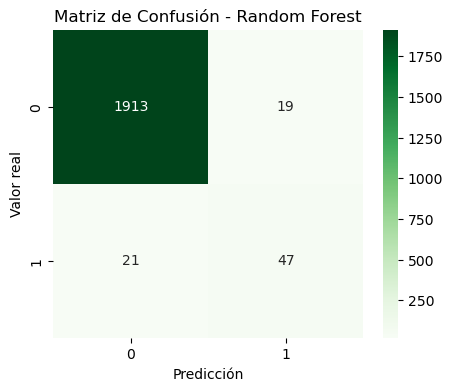

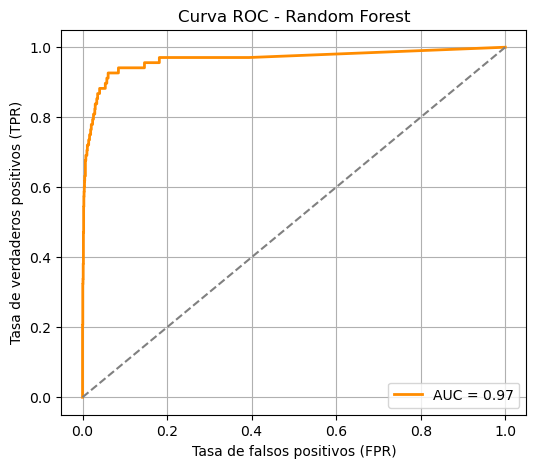

In [21]:
# Predicciones del modelo final
y_pred_rf = mejor_rf.predict(X_test)
y_prob_rf = mejor_rf.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report - Random Forest Optimizado")
print(classification_report(y_test, y_pred_rf))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
